In [1]:
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator, load_img 
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten 
from keras import optimizers 
from tensorflow.keras.optimizers import Adam, RMSprop, SGD 
from keras.callbacks import ModelCheckpoint,EarlyStopping 
import datetime 
from keras import regularizers 
import matplotlib.pyplot as plt 
from keras.utils.vis_utils import plot_model 
from keras.callbacks import ReduceLROnPlateau

In [2]:
!gdown https://drive.google.com/uc?id=1eN8WX8CoAsaZG98LhvuBOifE6sszvG6E

Downloading...
From: https://drive.google.com/uc?id=1eN8WX8CoAsaZG98LhvuBOifE6sszvG6E
To: /content/fer2013.zip
100% 63.3M/63.3M [00:00<00:00, 77.3MB/s]


In [3]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [4]:
train_dir = "/content/train/"
test_dir ="/content/test/"
classes = 7

def count_exp(path, set_):
  dict_ = {}
  for expression in os.listdir(path):
    dir_ = path + expression
    dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    
  return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  neutral  happy  angry   sad  disgust  fear
train      3171     4965   7215   3995  4830      436  4097
      surprise  neutral  happy  angry   sad  disgust  fear
test       831     1233   1774    958  1247      111  1024


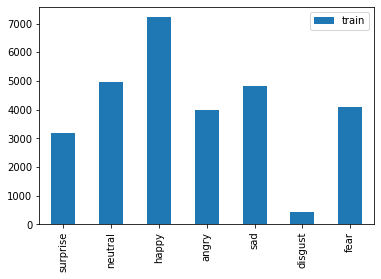

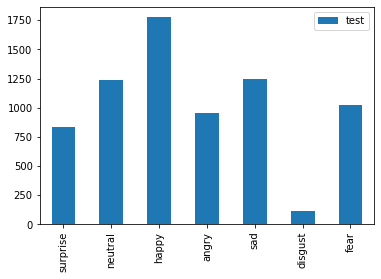

In [5]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

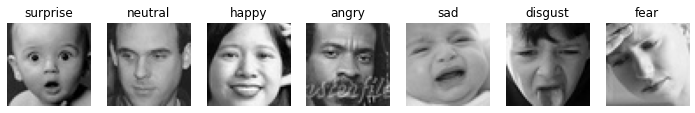

In [6]:
plt.figure(figsize=(14,22))
i = 1

for expression in os.listdir(train_dir):
  img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
  plt.subplot(1,8,i)
  plt.imshow(img)
  plt.title(expression)
  plt.axis('off')
  i += 1
  
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
training_set = train_datagen.flow_from_directory(train_dir, batch_size=64, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical', subset='training')
validation_set = train_datagen.flow_from_directory(train_dir, batch_size=64, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir, batch_size=64, target_size=(48,48), shuffle=True, color_mode='grayscale', class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
weight_decay = 1e-4
num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(256, activation="linear"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = Adam(0.0001) , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

In [9]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 5), 
                ModelCheckpoint( filepath='model.weights.best.hdf5', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size
history = model.fit(x=training_set, validation_data=validation_set, epochs=40, callbacks=[checkpointer], steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/40
358/358 [==============================] - ETA: 0s - loss: 2.3162 - accuracy: 0.2303
Epoch 1: val_accuracy improved from -inf to 0.21067, saving model to model.weights.best.hdf5
358/358 [==============================] - 39s 69ms/step - loss: 2.3162 - accuracy: 0.2303 - val_loss: 2.0764 - val_accuracy: 0.2107
Epoch 2/40
358/358 [==============================] - ETA: 0s - loss: 2.0744 - accuracy: 0.3008
Epoch 2: val_accuracy improved from 0.21067 to 0.35709, saving model to model.weights.best.hdf5
358/358 [==============================] - 23s 64ms/step - loss: 2.0744 - accuracy: 0.3008 - val_loss: 1.8321 - val_accuracy: 0.3571
Epoch 3/40
358/358 [==============================] - ETA: 0s - loss: 1.9031 - accuracy: 0.3547
Epoch 3: val_accuracy improved from 0.35709 to 0.43329, saving model to model.weights.best.hdf5
358/358 [==============================] - 24s 66ms/step - loss: 1.9031 - accuracy: 0.3547 - val_loss: 1.6459 - val_accuracy: 0.4333
Epoch 4/40
358/358 [========

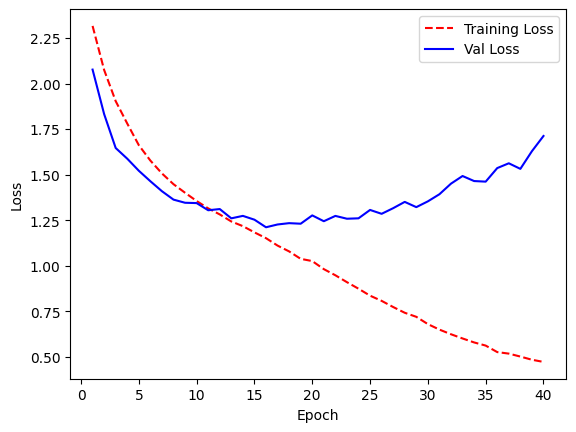

In [10]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

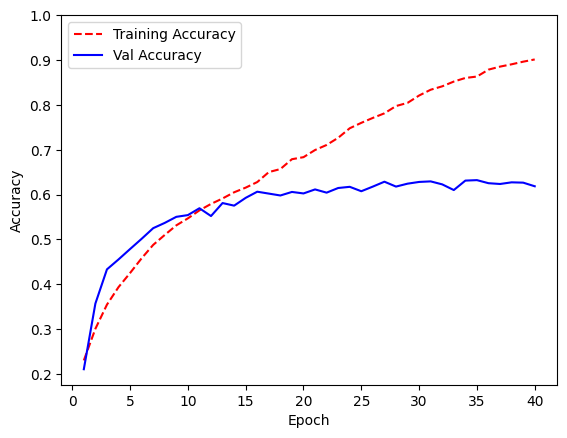

In [11]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)
# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [14]:
model.save("fer7_model.h5")

In [12]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%") 

112/112 [==============================] - 3s 22ms/step - loss: 1.4377 - accuracy: 0.6431
Test accuracy = 64.31361436843872%


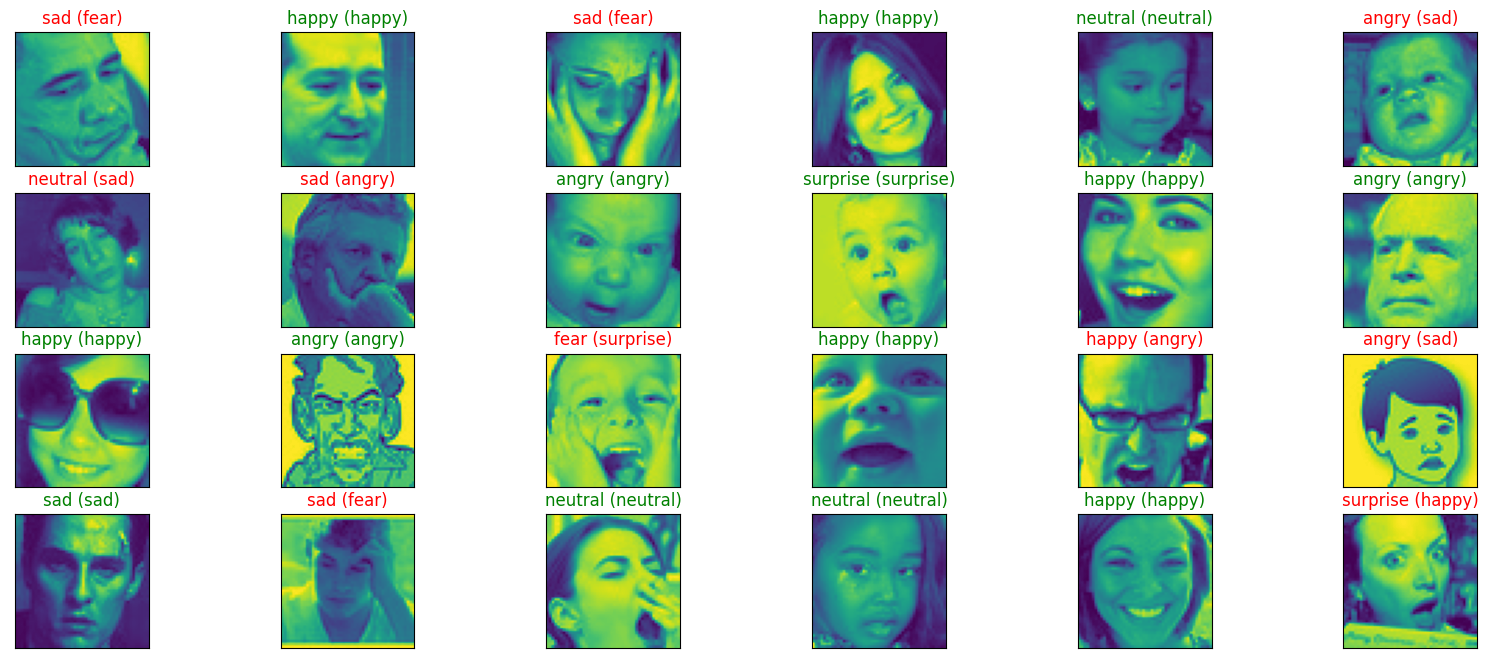

In [13]:
x_test,y_test = next(test_set)
predict = model.predict(x_test)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
  ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[index]))
  predict_index = class_labels[(np.argmax(predict[index]))]
  true_index = class_labels[(np.argmax(y_test[index]))]
  ax.set_title("{} ({})".format((predict_index),
  (true_index)),color=("green" if predict_index == true_index else "red"))

In [19]:
!pwd

/content


In [20]:
!python run.py

2022-06-21 14:48:57.688916: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
[ WARN:0] global /io/opencv/modules/videoio/src/cap_v4l.cpp (802) open VIDEOIO ERROR: V4L: can't open camera by index 0

